In [20]:
%matplotlib inline
import numpy as np
import scipy as sp
from utils import functions_3D as F3D
import matplotlib.pyplot as plt
plt.style.use(r'utils/mplstyle')

from matplotlib import gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import proj3d
import quaternion
import time

from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)
    
# generate a 2-sphere for plotting

THETA = np.linspace(1e-4, np.pi - 1e-4, 200)
PHI = np.linspace(0, np.pi * 2, 200)

THETA, PHI = np.meshgrid(THETA, PHI)

X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)

In [21]:
# nice colours to use

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fb9d32', '#fec787']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [22]:
seed = 219
std = 0.25
maxL = 5 # l = 2, ..., maxL

alpha = 0.150
f = np.sin(alpha)
g = np.cos(alpha)

np.random.seed(seed)
As = np.random.normal(0, std, (maxL + 1) ** 2 - 1 - 3) # * np.array([0, 1, 1, 0, 0])
Ps = np.random.random(len(As)) * np.pi * 2

ball = F3D.ball(maxL, As, Ps)

In [23]:
# check the curvature across the ball
ball.check_kappa(grid_point = 100)

# render the ball info, to be used for draw_ball etc.
ball.make_ball(grid_point = 200, keep = True);

# print critical ramp angle
QStar = np.max(ball.QFact)
alphaStar = np.arctan(QStar)
print(alphaStar)

Maximum and minimum curvatures are: 1.66 and 0.33. These will be used to set upper and lower bounds on cmaps
0.1387067484434942


In [24]:
# load Poincare data. simulations are done using the cell below

with open('3DData_simulation/Poincare_sweep.npy', 'rb') as file:
    Q_RES = np.load(file)
    T_RES = np.load(file)
N_points = len(Q_RES[0])

In [25]:
# np.random.seed(42)
# N_points = 5000
# 
# # generate a lot of points on the unit 2-sphere, these are the initial positions of Q for the Poincare section
# # to ensure uniform sampling, we first generate a Gaussian point cloud
# # then we bring them onto the 2-sphere by normalising their distances to the origin
# zz = []
# for i in range(N_points):
#     x1 = np.random.randn(3)
#     zz.append(x1  / (np.sqrt(np.sum(x1 ** 2))))
# zz = np.array(zz)
# 
# # set initial contact angles
# THETA_INI = np.arccos(zz[:,2])
# PHI_INI = np.arctan2(zz[:,1], zz[:,0])  # Azimuthal angle in [-pi, pi]
# PHI_INI[PHI_INI < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]
# 
# # every T_interval, check whether Q hits the 2-sphere. Continue simulation if not
# # if there is a sign change in the real part of Q, record the Q where this occured - this is the jump
# T_interval = 50 
# t_thre = 1 # threshold for time from one point on the 2-sphere to the other, mostly due to numerical issues
# 
# # start and finish Qs, and times
# Q_RES = np.zeros((2, N_points, 4))
# T_RES = np.zeros((2, N_points))
# 
# # I'm using a for loop here but multiprocessing also works well
# # I did this when I went to the gym so I don't care if it takes 5 hours :P
# t0 = time.time()
# for i in [2322]:# range(N_points):
#     
#     ball.initialisation(THETA_CT = THETA_INI[i], PHI_CT = PHI_INI[i], spin = 'AUTO')
#     count = 0
#     # _qful = []
#     running = True
#     while running:
#         # continue the simulation 
#         ball.simulate(f = f, g = g, ti = 0, tf = T_interval, outputN = 1000)
#         # _qful.append(ball.s[:, 2:6])
#         
#         # check whether Q has crossed the 2-sphere
#         
#         _q0 = ball.s[1:, 2]
#         
#         # at count = 0, the initial Q is supposed to be the starting point
#         # however, Q can change sign in a very very short time interval due to numerical issues
#         # so initially we assume this Q is indeed the start, but check this is the case only later
#         if count == 0:
#             Q_RES[0, i] = ball.s[1, 2:6]
#             T_RES[0, i] = ball.t[1]
#         count += 1
#         
#         # check whether the Q scalar part changed sign from the initial Q
#         _qs = (_q0 > 0).astype(int) # sign of q0
#         _id = np.where(_qs != (Q_RES[0, i, 0] > 0).astype(int))[0]
#         
#         if len(_id) > 0:
#             # if the change happened really early (sooner than t_thre)
#             # then this is probably an artefact
#             # we set this new point as the starting Q instead
#             if (count == 1) & (ball.t[_id[0] + 1] < t_thre):
#                 Q_RES[0, i] = ball.s[_id[0] + 1, 2:6]
#                 T_RES[0, i] = ball.t[_id[0] + 1]
#                 # now we want to check again that the Q scalar part did/did not change sign
#                 _id = np.where(_qs[_id[0] + 1:] != (Q_RES[0, i, 0] > 0).astype(int))[0]
#                 
#                 # changed sign again - this is the actual signal
#                 if len(_id) > 0:
#                     Q_RES[1, i] = ball.s[_id[0] + 1, 2:6]
#                     T_RES[1, i] = ball.t[_id[0] + 1]
#                     running = False
#             # if the sign change occurred at a typical time, then this is ok
#             else:
#                 Q_RES[1, i] = ball.s[_id[0] + 1, 2:6]
#                 T_RES[1, i] = ball.t[_id[0] + 1]
#                 running = False
#                 
#         qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))
#         qB = np.quaternion(*ball.s[-1, 2 : 6])
#         qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
#         qC3 = np.clip(quaternion.as_float_array(qB * qA.conjugate())[3], -1, 1)
#         if qC0 > 0:
#             spin = np.arcsin(qC3) * 2    
#         else:
#             if qC3 > 0:
#                 spin = (np.pi - np.arcsin(qC3)) * 2
#             else:
#                 spin = (- np.pi - np.arcsin(qC3)) * 2
#         ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin)
#     print('simulation for {0}, average time spent = {1:.2f} s'.format(i, (time.time() - t0) / (i + 1)), end = '\r')
# Q_RES *= np.sign(Q_RES)[:, :, 0][:, :, np.newaxis] # pull all q to have a positive scalar part

# with open('3DData_simulation/Poincare_sweep.npy', 'wb') as file:
#     np.save(file, Q_RES)
#     np.save(file, T_RES)

In [26]:
# compute quiver (Poincare map)

QuiverXYZ = []
QuiverUVW = []
QuiverMag = []

for i in range(N_points):

    _Q0 = Q_RES[0, i, 1:]
    _Q1 = Q_RES[1, i, 1:]
    cosang = np.clip(np.sum(_Q0 * _Q1), -1, 1)

    ang = np.arccos(cosang)
    pos = _Q1 - _Q0 * cosang
    pos /= np.sqrt(np.sum(pos ** 2))

    QuiverXYZ.append(_Q0)
    QuiverUVW.append(pos)
    QuiverMag.append(ang)

    # the poincare section has inversion symmetry about the origin
    # so we add the mirror by hand

    QuiverXYZ.append(- _Q0)
    QuiverUVW.append(- pos)
    QuiverMag.append(ang)
    
QuiverXYZ = np.array(QuiverXYZ)
QuiverUVW = np.array(QuiverUVW)
QuiverMag = np.array(QuiverMag)

normMag = QuiverMag / np.max(QuiverMag)
colorMag = cm.plasma((normMag + 0.1)/(1.1))

[x, y, z] = QuiverXYZ.T
[u, v, w] = QuiverUVW.T

In [27]:
# load stable orbits data data. simulations are done using the cell below

STABLE_ORB = []
with open('3DData_simulation/Poincare_stable.npy', 'rb') as file:
    for i in range(2):
        STABLE_ORB.append(np.load(file))

In [28]:
# # finally, compute the 2 stable orbits. the initialisations are chosen for fast convergence for this seed (219)
# 
# STABLE_ORB = []
# STABLE_INI = np.array([[1.78, -1.00, 4.5], [1.17, 2.96, -2.459]])
# 
# T_interval = 50 
# 
# for ini_con in STABLE_INI:
#     _qful = []
#     ball.initialisation_simple(THETA_CT = ini_con[0], PHI_CT = ini_con[1], spin = ini_con[2])
# 
#     for i in range(6):
#         ball.simulate(f = f, g = g, ti = 0, tf = T_interval, outputN = 1000)
#         _qful.append(ball.s[1:, 2:6])
# 
#         qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))
#         qB = np.quaternion(*ball.s[-1, 2 : 6])
#         qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
#         qC3 = quaternion.as_float_array(qB * qA.conjugate())[3]
#         if qC0 > 0:
#             spin = np.arcsin(qC3) * 2    
#         else:
#             if qC3 > 0:
#                 spin = (np.pi - np.arcsin(qC3)) * 2
#             else:
#                 spin = (- np.pi - np.arcsin(qC3)) * 2
#         ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin)
#         
#     _qful = np.vstack(_qful)
#     _seg = (np.sign(_qful[:, 0]) == np.sign(_qful[-1, 0]))
#     _lst = np.where(_seg != _seg[-1])[0][-1]
#     _fst = np.where(_seg[:_lst] != _seg[_lst])[0][-1] + 1
#     _qful *= np.sign(_qful)[:, 0][:, np.newaxis] # pull all q to have a positive scalar part
#     
#     STABLE_ORB.append(_qful[_fst:_lst])
# 
# with open('3DData_simulation/Poincare_stable.npy', 'wb') as file:
#     for i in range(len(STABLE_ORB)):
#         np.save(file, STABLE_ORB[i])

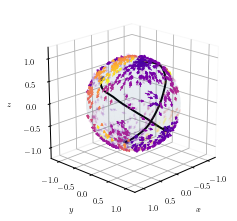

In [33]:
fig = plt.figure(figsize = (5, 3))

ax1 = fig.add_subplot(1,1,1, projection='3d')
ax1.set_box_aspect((1,1,1))

azim = 44
elev = 20
ax1.view_init(elev=elev, azim=azim)
# we manually set the arrow transparency depending on whether they are in front or behind the 2-sphere
camera_vec = np.array([np.cos(elev / 180 * np.pi) * np.cos(azim / 180 * np.pi),
                       np.cos(elev / 180 * np.pi) * np.sin(azim / 180 * np.pi),
                       np.sin(elev / 180 * np.pi)])

[x, y, z] = QuiverXYZ.T
[u, v, w] = QuiverUVW.T
mag = 0.2

plot_prob = 0.1 # there are a lot of arrows, so plot only a portion of it
seed = 234
np.random.seed(seed)
for i in range(len(x)):
    if np.random.rand() < plot_prob:
        if np.sum(np.array([x[i], y[i], z[i]]) * camera_vec) > 0:
            a = Arrow3D([x[i] - u[i] * mag * 0, x[i] + u[i] * mag],
                        [y[i] - v[i] * mag * 0, y[i] + v[i] * mag],
                        [z[i] - w[i] * mag * 0, z[i] + w[i] * mag], mutation_scale=5,
                        lw=1.0, arrowstyle="-|>", color=colorMag[i], alpha = 1)
            ax1.add_artist(a)
        else:
            a = Arrow3D([x[i] - u[i] * mag * 0, x[i] + u[i] * mag],
                        [y[i] - v[i] * mag * 0, y[i] + v[i] * mag],
                        [z[i] - w[i] * mag * 0, z[i] + w[i] * mag], mutation_scale=5,
                        lw=1.0, arrowstyle="-|>", color=colorMag[i], alpha = 0.1)
            ax1.add_artist(a)

for i in range(2):
    _orb = STABLE_ORB[i]
    ax1.plot(_orb[:, 1], _orb[:, 2], _orb[:, 3], color = 'black', lw = 2)
    ax1.scatter(_orb[[0,-1], 1], _orb[[0,-1], 2], _orb[[0,-1], 3], color = 'black')

ax1.plot_surface(X, Y, Z, alpha = 0.05, zorder = -100)

ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-1.2, 1.2)
ax1.set_zlim(-1.2, 1.2)

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$z$')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

plt.tight_layout()
# plt.axis('off')
plt.savefig('3DPlots/Poincare.png', transparent = True, dpi = 300)

In [35]:
# # loop for making a video of this
# 
# for azim in range(360):
# 
#     fig = plt.figure(figsize = (5, 3))
# 
#     ax1 = fig.add_subplot(1,1,1, projection='3d')
#     ax1.set_box_aspect((1,1,1))
# 
#     # azim = 44
#     elev = 20
#     ax1.view_init(elev=elev, azim=azim)
#     # we manually set the arrow transparency depending on whether they are in front or behind the 2-sphere
#     camera_vec = np.array([np.cos(elev / 180 * np.pi) * np.cos(azim / 180 * np.pi),
#                            np.cos(elev / 180 * np.pi) * np.sin(azim / 180 * np.pi),
#                            np.sin(elev / 180 * np.pi)])
# 
#     [x, y, z] = QuiverXYZ.T
#     [u, v, w] = QuiverUVW.T
#     mag = 0.2
# 
#     plot_prob = 0.1 # there are a lot of arrows, so plot only a portion of it
#     seed = 234
#     np.random.seed(seed)
#     for i in range(len(x)):
#         if np.random.rand() < plot_prob:
#             if np.sum(np.array([x[i], y[i], z[i]]) * camera_vec) > 0:
#                 a = Arrow3D([x[i] - u[i] * mag * 0, x[i] + u[i] * mag],
#                             [y[i] - v[i] * mag * 0, y[i] + v[i] * mag],
#                             [z[i] - w[i] * mag * 0, z[i] + w[i] * mag], mutation_scale=5,
#                             lw=1.0, arrowstyle="-|>", color=colorMag[i], alpha = 1)
#                 ax1.add_artist(a)
#             else:
#                 a = Arrow3D([x[i] - u[i] * mag * 0, x[i] + u[i] * mag],
#                             [y[i] - v[i] * mag * 0, y[i] + v[i] * mag],
#                             [z[i] - w[i] * mag * 0, z[i] + w[i] * mag], mutation_scale=5,
#                             lw=1.0, arrowstyle="-|>", color=colorMag[i], alpha = 0.1)
#                 ax1.add_artist(a)
# 
#     for i in range(2):
#         _orb = STABLE_ORB[i]
#         ax1.plot(_orb[:, 1], _orb[:, 2], _orb[:, 3], color = 'black', lw = 2)
#         ax1.scatter(_orb[[0,-1], 1], _orb[[0,-1], 2], _orb[[0,-1], 3], color = 'black')
# 
#     ax1.plot_surface(X, Y, Z, alpha = 0.05, zorder = -100)
# 
#     ax1.set_xlim(-1.2, 1.2)
#     ax1.set_ylim(-1.2, 1.2)
#     ax1.set_zlim(-1.2, 1.2)
# 
#     ax1.set_xlabel('$x$')
#     ax1.set_ylabel('$y$')
#     ax1.set_zlabel('$z$')
#     ax1.xaxis.pane.fill = False
#     ax1.yaxis.pane.fill = False
#     ax1.zaxis.pane.fill = False
# 
#     plt.tight_layout()
#     plt.axis('off')
#     plt.savefig('3DPlots/temporary/{0:05d}.png'.format(azim), transparent = False, dpi = 300)
#     plt.close()

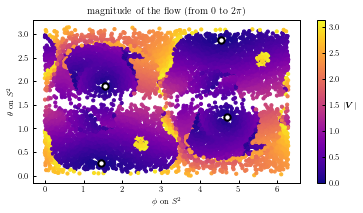

In [19]:
# finally we visualise the magnitude of the Poincare vectors (from 0 to π) on a 2D plot

# we parameterise the 2-sphere using polar angles again and use a color map to represent the magnitude

# it turns out the Poincare section is not as smooth as we expected. First, there are 2 removable singularities
# these are the bright spots near (2.50, 0.75) and (4.50, 2.70)
# they come from a trajectory just grazing the 2-sphere from the inside,
# so the starting and finishing points are very close on the 2-sphere, and 
# get sent far away when an antipodal itentification is done, leading to a vector length of almost 2π.
# since these are just islands, we can remove them manually to smoothen those parts

# for the rest of the space, we do see a lot more funfare
# these come from the 2 pairs of unstable fixed points that are not computed explicitly
# but you can probably find them by setting f -> -f and g -> -g
# and the unstable fixed points should sit at locations where large local |V| changes are seen

# to see this last point, we visualise the direction of the Poincare vectors by
# assigning polar and azimuthal angles to the vectors themselves
# and plotting scatter plots with the cmap depending on these angles.
# see plots further down

# set initial contact angles
tt = np.arccos(z)
pp = np.arctan2(y, x)  # Azimuthal angle in [-pi, pi]
pp[pp < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]

t0s = []
p0s = []
for i in range(2):
    _orb = STABLE_ORB[i]
    _t0 = np.arccos(_orb[[0,-1], 3])
    _p0 = np.arctan2(_orb[[0,-1], 2], _orb[[0,-1], 1])
    _p0[_p0 < 0] += 2 * np.pi
    t0s.append(_t0)
    p0s.append(_p0)

plt.figure(figsize = (6, 3))
plt.scatter(pp, tt, c = QuiverMag, cmap = cm.plasma, vmin = 0,vmax = np.pi, s = 10)
cbar = plt.colorbar()
cbar.set_label(r'$|\bm{V}|$', rotation = 0, labelpad = 10)

plt.scatter(p0s, t0s, s = 40, edgecolor = 'black', facecolor = 'white', lw = 2)

plt.xlabel(r'$\phi$ on $S^{2}$')
plt.ylabel(r'$\theta$ on $S^{2}$')
plt.title(r'magnitude of the flow (from 0 to $2\pi$)')

plt.savefig('3DPlots/Poincare_flat_magnitude.png', transparent = True, dpi = 300)

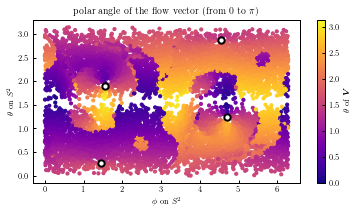

In [16]:
# set initial contact angles
tt = np.arccos(z)
pp = np.arctan2(y, x)  # Azimuthal angle in [-pi, pi]
pp[pp < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]

tt2 = np.arccos(w)
pp2 = np.arctan2(v, u)  # Azimuthal angle in [-pi, pi]
pp2[pp2 < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]

plt.figure(figsize = (6, 3))
plt.scatter(pp, tt, c = tt2, cmap = cm.plasma, vmin = 0, vmax = np.pi, s = 10)
cbar = plt.colorbar()
cbar.set_label(r'$\theta$ of $\bm{V}$')

plt.scatter(p0s, t0s, s = 40, edgecolor = 'black', facecolor = 'white', lw = 2)

plt.xlabel(r'$\phi$ on $S^{2}$')
plt.ylabel(r'$\theta$ on $S^{2}$')
plt.title(r'polar angle of the flow vector (from 0 to $\pi$)')

plt.savefig('3DPlots/Poincare_flat_polar.png', transparent = True, dpi = 300)

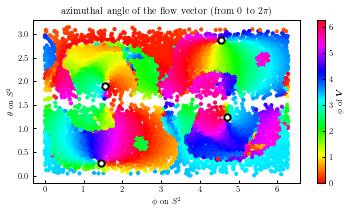

In [17]:
# visualise the alignment of the Poincare vectors

# set initial contact angles
tt = np.arccos(z)
pp = np.arctan2(y, x)  # Azimuthal angle in [-pi, pi]
pp[pp < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]

tt2 = np.arccos(w)
pp2 = np.arctan2(v, u)  # Azimuthal angle in [-pi, pi]
pp2[pp2 < 0] += 2 * np.pi  # Adjust phi to be in [0, 2pi]

plt.figure(figsize = (6, 3))
plt.scatter(pp, tt, c = pp2, cmap = cm.hsv, vmin = 0, vmax = 2 * np.pi, s = 10)
cbar = plt.colorbar()
cbar.set_label(r'$\phi$ of $\bm{V}$')

plt.scatter(p0s, t0s, s = 40, edgecolor = 'black', facecolor = 'white', lw = 2)

plt.xlabel(r'$\phi$ on $S^{2}$')
plt.ylabel(r'$\theta$ on $S^{2}$')
plt.title(r'azimuthal angle of the flow vector (from 0 to $2\pi$)')

plt.savefig('3DPlots/Poincare_flat_azimuthal.png', transparent = True, dpi = 300)